# Ranking and Personalization Modeling for Recommender Systems

---



# Introduction 

In this session, we will walk through how to train a model for a personalized movie recommender system. We'll use two open-source libraries:
- [GDMix](https://github.com/linkedin/gdmix), a framework to train fixed effect and random effect models, to handle personalization part;
- [DeText](https://github.com/linkedin/detext), a Deep Text understanding framework for NLP tasks, to handle text data such as movie title in today's example. 







# Prerequisite
- Install Spark 2.4.6 and download GDMix-data jar for intermediate data processing
- Install GDMix Python packages

In [4]:
#@title Download and Install Spark 2.4.6

!apt update && apt-get install openjdk-8-jdk-headless tree -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-2.4.6/spark-2.4.6-bin-hadoop2.7.tgz
!rm -rf /opt/spark && mkdir /opt/spark
!tar -xf spark-2.4.6-bin-hadoop2.7.tgz && \
    mv spark-2.4.6-bin-hadoop2.7/* /opt/spark/ && \
    sed -i s/INFO/ERROR/g /opt/spark/conf/log4j.properties.template && \
    mv /opt/spark/conf/log4j.properties.template /opt/spark/conf/log4j.properties && \
    rm -rf spark-*
# Setup env variables
%env JAVA_HOME=/usr/lib/jvm/java-1.8.0-openjdk-amd64/jre
%env SPARK_HOME=/opt/spark
%env SPARK_CLASSPATH=/opt/spark/jars/
%env PATH=/opt/spark/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Fetched 88.7 kB in 2s (47.7 kB/s)
Reading package lists... Done
Building dependency tree       
Reading state information..

In [5]:
#@title Verify if Spark installation, expect to see "Pi is roughly 3.14..."

!spark-submit --class org.apache.spark.examples.SparkPi  --master local[*] /opt/spark/examples/jars/spark-examples_2.11-2.4.6.jar

20/08/26 22:34:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Pi is roughly 3.143275716378582


In [6]:
#@title Download gdmix-data fat jar for intermediate data processing
!wget https://linkedin.bintray.com/maven/com/linkedin/gdmix/gdmix-data-all_2.11/0.1.0/gdmix-data-all_2.11-0.1.0.jar

--2020-08-26 22:34:22--  https://linkedin.bintray.com/maven/com/linkedin/gdmix/gdmix-data-all_2.11/0.1.0/gdmix-data-all_2.11-0.1.0.jar
Resolving linkedin.bintray.com (linkedin.bintray.com)... 35.161.162.245, 54.148.239.199, 52.88.32.158, ...
Connecting to linkedin.bintray.com (linkedin.bintray.com)|35.161.162.245|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://akamai.bintray.com/3f/3ff28ee08b9b2fc85addbdbfd2a32af3884bff98af84a2369d273b1db838624d?__gda__=exp=1598481983~hmac=f63b03b23471ae807389c49b9fc0d954badcc13c4b053c9b5445e1ae226e5f25&response-content-disposition=attachment%3Bfilename%3D%22gdmix-data-all_2.11-0.1.0.jar%22&response-content-type=application%2Fjava-archive&requestInfo=U2FsdGVkX1-QcLO4SSvtCjeMpWZu5TyWKRFZfjCKuJc4gA8aOAkuH8e3dj_ohFJwN7tobWOA1_ebyhWm1ZOa_jOB5BOX4nrgadt4Fegd0-BxdDdIF7BeemLHeph3JbP1Jy-HV1WRbiAADuzhmFz5x2njddeiphjPW6MmgzL6B-g&response-X-Checksum-Sha1=9c06be132270f10ab2eafbdfda93109f0d6dc9db&response-X-Checksum-Sha2=3ff28ee08b

In [7]:
#@title Install GDMix Python packages
!pip install gdmix-trainer gdmix-workflow

  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=162dcc65a5a0c9de193437084b3d37374339487f99e9868a8cf7f70883a05e8b
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement cloudpickle==1.3, but you'll have cloudpickle 1.1.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: detext 2.0.5 has requirement numpy<1.17, but you'll have numpy 1.18.5 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


# Outline
- Introduction of Generalized Linear Mixed (GLMix) and Generalized Deep Mixed (GDMix) Model for Recommender Systems
- Train a pointwise ranking and personalization model to recommend movies using MovieLens data
  - MovieLen Data download and preprocessing
  - Train a GLMix model
  - Train a GDMix model
  - Compare the two models

# Introduction of Generalized Linear Mixed Model (GLMix) and Generalized Deep Mixed Model (GDMix) for Recommender System

--------

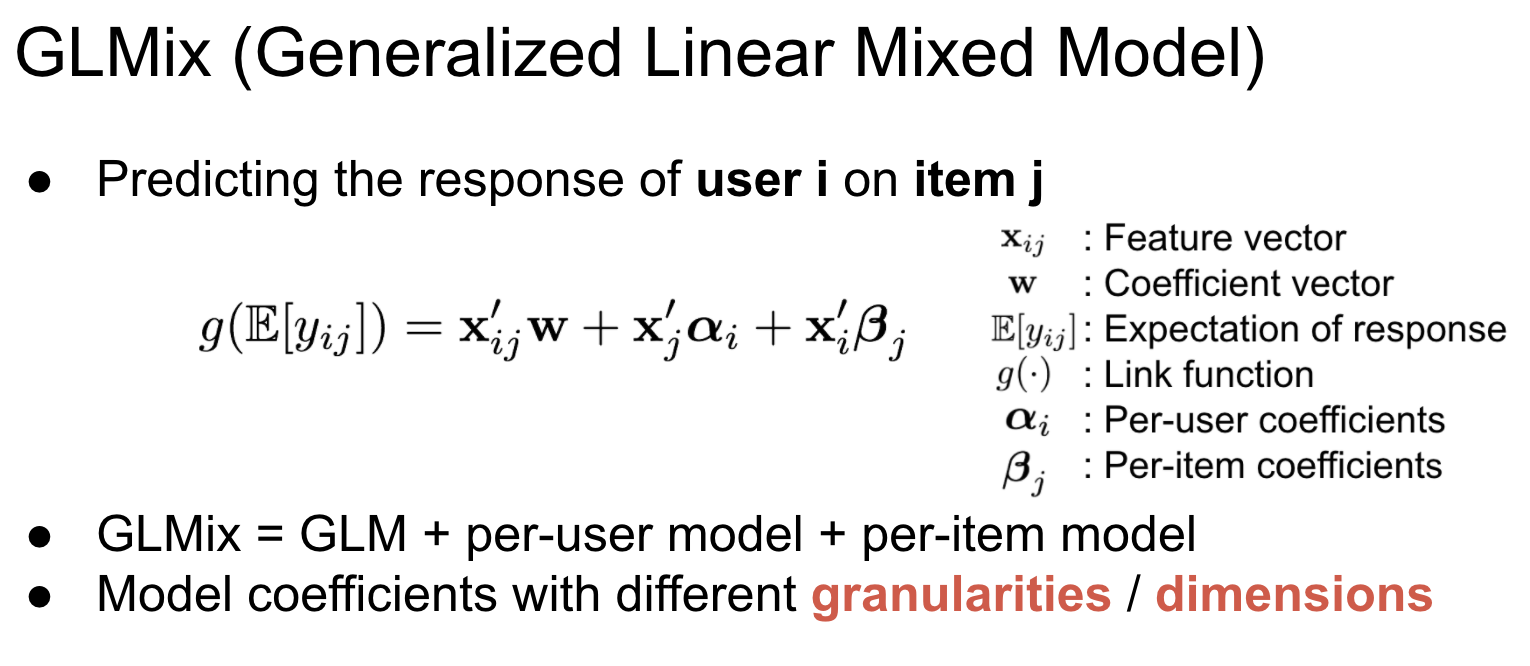

--------

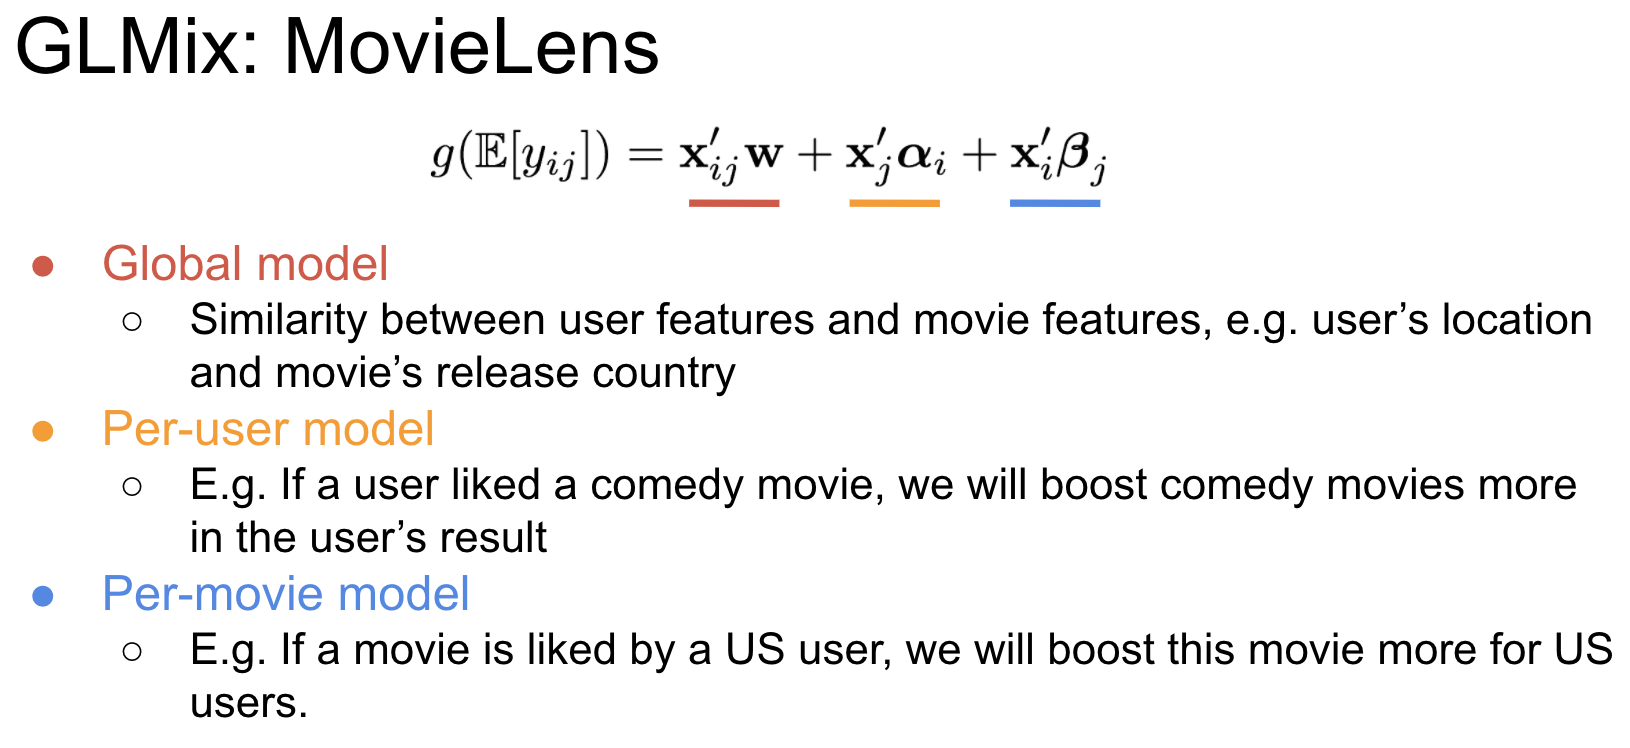

--------

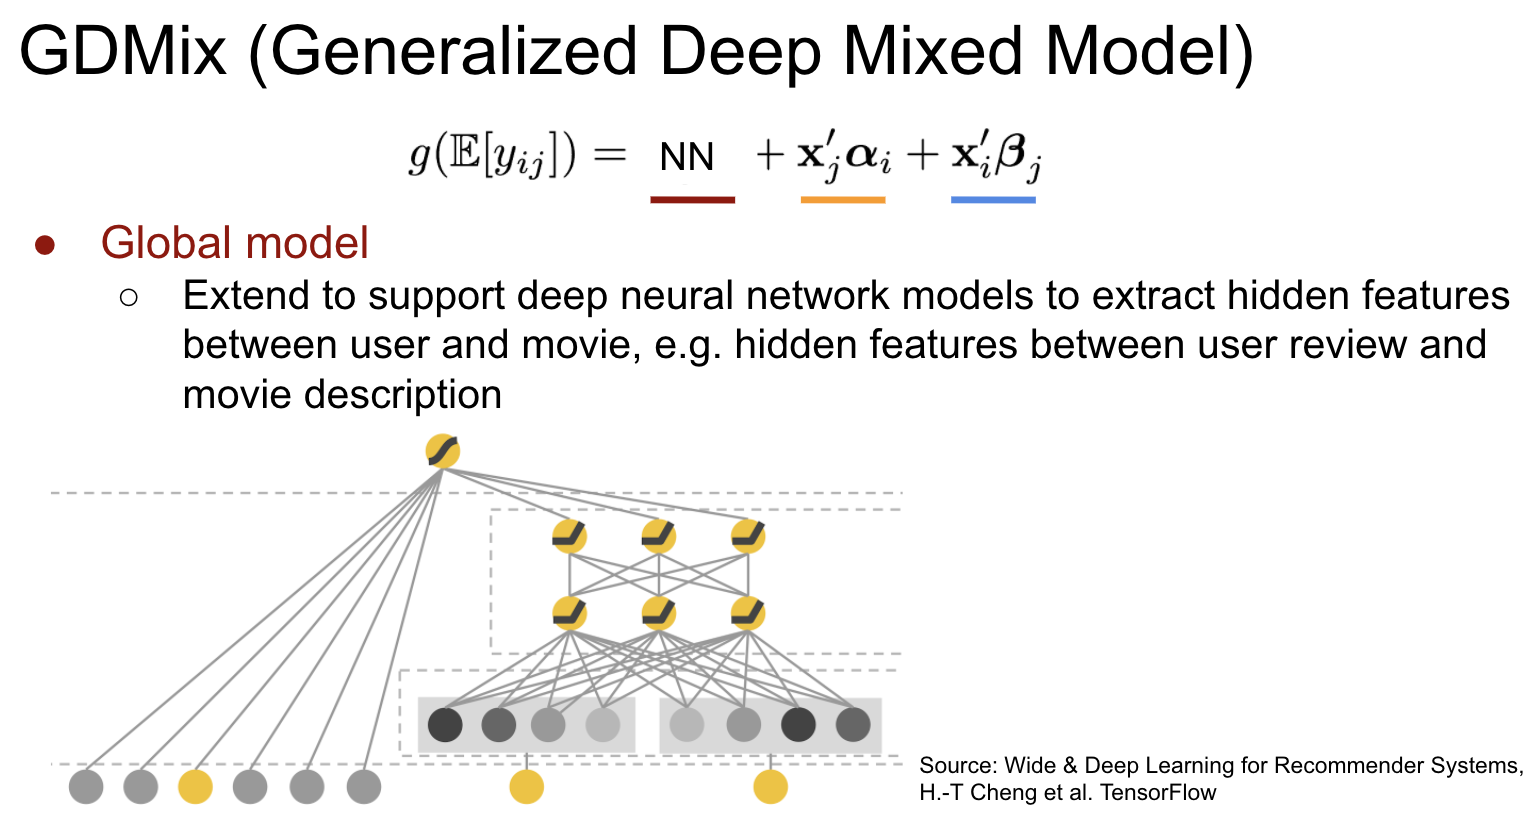

--------

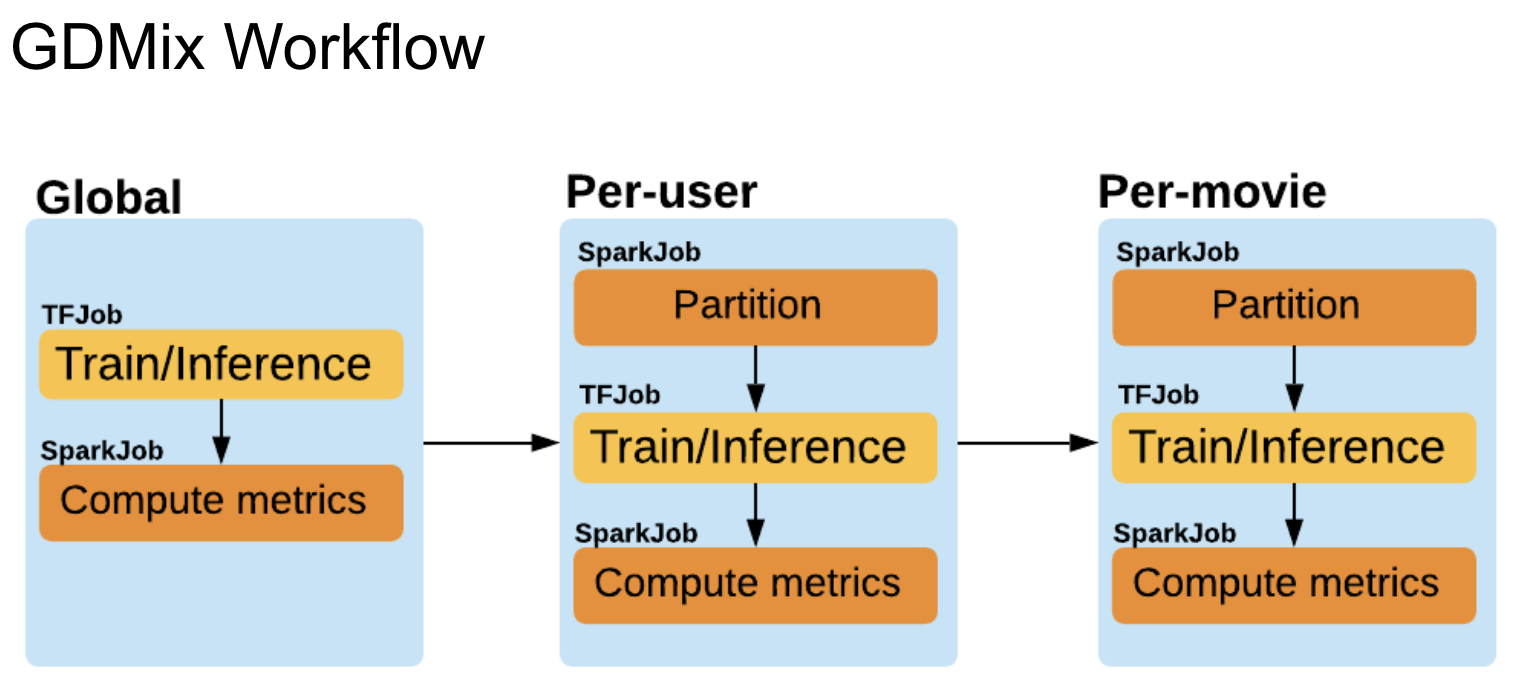

------

# MovieLens Data Download and Preprocess

## Download MovieLens data ([Kaggle movieLens-100k-dataset](https://www.kaggle.com/prajitdatta/movielens-100k-dataset))

In [8]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip && unzip ml-100k.zip

--2020-08-26 22:34:27--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  16.1MB/s    in 0.3s    

2020-08-26 22:34:28 (16.1 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

## Preprocess Data 
We will train 3 models, need to specify different features for each of them
- **per-user**: age, gender and occupation
- **per-movie**: genre and release date
- **global**: age, gender, occupation, genre and release date

In [9]:
import json
import numpy as np
import os
import pandas as pd
import pickle
import re
import shutil
import string
import tensorflow as tf
import sys
from pprint import pprint

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

### Define data preprocessing input and output directories

In [10]:
input_dir = "ml-100k"
output_dir = "movieLens"

### Specifiy features and indexing them for each model

In [11]:
GENRE = ['unknown', 'Action', 'Adventure', 'Animation',
         'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
         'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi',
         'Thriller', 'War', 'Western']
USER_FEATURE_COLUMNS = ['age', 'gender', 'occupation']
MOVIE_FEATURE_COLUMNS = GENRE + ['release_date']
USER_FEATURE_VALUES = ['age', 'M', 'F', 'administrator', 'artist', 'doctor', 'educator', 'engineer',
                       'entertainment', 'executive', 'healthcare', 'homemaker', 'lawyer',
                       'librarian', 'marketing', 'none', 'other', 'programmer', 'retired',
                       'salesman', 'scientist', 'student', 'technician', 'writer']
MOVIE_FEATURE_VALUES = MOVIE_FEATURE_COLUMNS

DETEXT_LABEL = 'label'
DETEXT_QUERY = 'doc_query'
DETEXT_WIDE_IDX = 'wide_ftrs_sp_idx'
DETEXT_WIDE_VAL = 'wide_ftrs_sp_val'

GLOBAL_FEATURE_VALUES = USER_FEATURE_VALUES + MOVIE_FEATURE_VALUES
GLOBAL_INDEX_MAP = {GLOBAL_FEATURE_VALUES[i]: i for i in range(len(GLOBAL_FEATURE_VALUES))}

USER_INDEX_MAP = {USER_FEATURE_VALUES[i]: i for i in range(len(USER_FEATURE_VALUES))}

MOVIE_INDEX_MAP = {MOVIE_FEATURE_VALUES[i]: i for i in range(len(MOVIE_FEATURE_VALUES))}

### Define feature Tensor metadata for each model

In [12]:
global_metadata = {
    "features": [{
        "name": "global",
        "dtype": "float",
        "shape": [len(GLOBAL_FEATURE_VALUES)],
        "isSparse": True
    }, {
        "name": "uid",
        "dtype": "int",
        "shape": [],
        "isSparse": False
    }, {
        "name": "movie_id",
        "dtype": "int",
        "shape": [],
        "isSparse": False
    }, {
        "name": "user_id",
        "dtype": "int",
        "shape": [],
        "isSparse": False
    }],
    "labels" : [{
        "name": "response",
        "dtype": "int",
        "shape": [],
        "isSparse": False
    }]
}

per_user_metadata = {
    "features": [{
        "name": "per_user",
        "dtype": "float",
        "shape": [len(MOVIE_FEATURE_VALUES)],
        "isSparse": True
    }, {
        "name": "uid",
        "dtype": "int",
        "shape": [],
        "isSparse": False
    }, {
        "name": "movie_id",
        "dtype": "int",
        "shape": [],
        "isSparse": False
    }, {
        "name": "user_id",
        "dtype": "int",
        "shape": [],
        "isSparse": False
    }],
    "labels" : [{
        "name": "response",
        "dtype": "int",
        "shape": [],
        "isSparse": False
    }]
}

per_movie_metadata = {
    "features": [{
        "name": "per_movie",
        "dtype": "float",
        "shape": [len(USER_FEATURE_VALUES)],
        "isSparse": True
    }, {
        "name": "uid",
        "dtype": "int",
        "shape": [],
        "isSparse": False
    }, {
        "name": "movie_id",
        "dtype": "int",
        "shape": [],
        "isSparse": False
    }, {
        "name": "user_id",
        "dtype": "int",
        "shape": [],
        "isSparse": False
    }],
    "labels" : [{
        "name": "response",
        "dtype": "int",
        "shape": [],
        "isSparse": False
    }]
}

### Some utility functions: 
- `cleanup_text`: convert to lower case, remove punctuation and extra white space et.al
- `read_data`: using pandas to read data
- `process_data`: process data, for example, join features by id, normalize feature values, et.al
- `tensorize_data`: tensorize data(sparse tensor) so that they can be consumed by Tensorflow dataset API
- `generate_or_load_train_test_masks`: generate masks for spliting the dataset into train and test by given percentage
- `split_train_test`: split dataset into train and test datasets
- `prepare_dir`: remove directory if exists, then create one
- `save_tfrecord`: serialize data to TF record
- `create_metadata`: dump metadata for deserialization
- `write_feature_list`: dump feature names of each mode

In [13]:
def cleanup_text(input):
    """remove release data which is at the end of the title e.g. (1995)"""
    input = re.sub(r'\([^)]*\)$', '', input)
    tokens = []
    for d in input.split():
        t = d.strip().lower()
        t = re.sub(r'([%s])' % re.escape(string.punctuation), r' ', t)
        t = re.sub(r'\\.', r' ', t)
        t = re.sub(r'\s+', r' ', t)
        t = t.strip()
        tokens.append(t)
    sentence = ' '.join(tokens)
    return sentence


def read_data(data_dir):
    """Read the data using pandas. """
    data_names = ['user_id', 'movie_id', 'rating', 'timestamp']
    # drop timestamp
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', names=data_names).drop('timestamp', 1)
    item_names = ['movie_id', 'title', 'release_date', 'video_release_date',
                  'IMDb_URL'] + GENRE
    items = pd.read_csv(os.path.join(data_dir, 'u.item'), '|', names=item_names, encoding = "ISO-8859-1")
    # clean up title
    items = items.drop(['video_release_date', 'IMDb_URL'], 1)
    items['title'] = items['title'].apply(cleanup_text)
    user_names = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
    # drop zip_code
    users = pd.read_csv(os.path.join(data_dir, 'u.user'), '|', names=user_names).drop('zip_code', 1)
    return data, items, users


def process_data(data, items, users):
    """Process data such as join features by id, normalize feature values, et.al. """
    # normalized release_date by 2020
    items['release_date'] = items['release_date'].apply(lambda x: float(str(x).split('-')[-1]) / 2000.0)
    # normalized the age:
    users['age'] = users['age'] / 100.0
    # append uid to data
    data.insert(0, 'uid', range(len(data)))
    # binarize the score, use 3.0 as threshold.
    data['response'] = data['rating'].apply(lambda x: 1 if x > 3.0 else 0)
    data = data.drop('rating', 1)
    # create per_movie dataset, per-movie features are user features
    per_movie = data.join(users.set_index('user_id'), on='user_id', lsuffix='', rsuffix='_other')
    # create per_user dataset, per_user features are movie features
    per_user = data.join(items.set_index('movie_id'), 'movie_id', lsuffix='', rsuffix='_other')
    # join to create the global_data
    global_data = per_user.join(users.set_index('user_id'), 'user_id', lsuffix='', rsuffix='_other')
    global_data.sort_values(by=['uid'], inplace=True)
    per_movie.sort_values(by=['uid'], inplace=True)
    per_user.sort_values(by=['uid'], inplace=True)
    return global_data, per_movie, per_user


def tensorize_data(data, kept_columns, numeric_columns, categorical_columns, index_map, feature_bag):
    """Tensorize data so that they can be consumed by Tensorflow dataset API. """
    indices_name = f'{feature_bag}_indices'
    values_name = f'{feature_bag}_values'
    tdata = data.filter(kept_columns, axis=1)
    index_column = []
    value_column = []
    for i, row in enumerate(data.itertuples()):
        indices, values = [], []
        for key in row._fields:
            value = getattr(row, key)
            if key in numeric_columns:
                index = index_map[key]
            elif key in categorical_columns:
                index = index_map[value]
                value = 1.0
            else:
                # print(f'{key} is not used')
                continue
            if abs(value) > 1e-6:
                indices.append(index)
                values.append(float(value))
        # sort the indices
        indices, values = zip(*sorted(zip(indices, values)))
        index_column.append(indices)
        value_column.append(values)
    tdata[indices_name] = index_column
    tdata[values_name] = value_column
    return tdata


def generate_or_load_train_test_masks(data, train_percentage, output_file=None):
    """Generate masks for spliting the dataset into train and test by given percentage. """
    try:
        with open(output_file, 'rb') as f:
            return pickle.load(f)
        print(f'loaded from {output_file}')
    except FileNotFoundError:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < train_percentage]
        neg_mask = [not x for x in mask]
        if output_file:
            with open(output_file, 'wb') as f:
                pickle.dump((mask, neg_mask), f)
        return mask, neg_mask
    

def split_train_test(data, masks):
    """Split dataset into train and test datasets. """
    mask, neg_mask = masks[0], masks[1]
    train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data


def prepare_dir(directory):
    shutil.rmtree(directory, ignore_errors=True)
    os.makedirs(directory)
    

def save_tfrecord(data, feature_bag, other_features_map, label_name, output_file, detext=False):
    """Serialize data to TF record."""
    
    def get_example(row, feature_bag, other_features_map, label_name, detext):
        if detext:
            indices_name = DETEXT_WIDE_IDX
            values_name = DETEXT_WIDE_VAL
        else:
            indices_name = f'{feature_bag}_indices'
            values_name = f'{feature_bag}_values'
        tfr_features = {
            indices_name: tf.train.Feature(int64_list=tf.train.Int64List(
                value=getattr(row, indices_name))),
            values_name: tf.train.Feature(float_list=tf.train.FloatList(
                value=getattr(row, values_name))),
        }
        if detext:
            tfr_features[label_name] = tf.train.Feature(float_list=tf.train.FloatList(
                value=[getattr(row, label_name)]))
        else:
            tfr_features[label_name] = tf.train.Feature(int64_list=tf.train.Int64List(
                value=[getattr(row, label_name)]))
        for key in other_features_map:
            feature_type = other_features_map[key]
            feature = None
            if feature_type in [tf.int16, tf.int32, tf.int64]:
                feature = tf.train.Feature(int64_list=tf.train.Int64List(
                    value=[getattr(row, key)]))
            elif feature_type == tf.float:
                feature = tf.train.Feature(float_list=tf.train.FloatList(
                    value=getattr(row, key)))
            else:
                print(f'unknown type {feature_type}')
            if feature:
                tfr_features[key] = feature
        if detext:
            title = str.encode(getattr(row, DETEXT_QUERY))
            tfr_features[DETEXT_QUERY] = tf.train.Feature(bytes_list=tf.train.BytesList(
                value=[title]))
        features = tf.train.Features(feature=tfr_features)
        return tf.train.Example(features=features)
    
    with tf.io.TFRecordWriter(output_file) as writer:
        i = 0
        for row in data.itertuples():
            example = get_example(row, feature_bag, other_features_map, label_name, detext)
            i += 1
            if i < 2:
                print(example)
            writer.write(example.SerializeToString())
            

def create_metadata(metadata, outfile):
    """Dump metadata for deserialization."""
    with open(outfile, 'w') as f:
        json.dump(metadata, f)
        

def write_feature_list(features, outfile):
    with open(outfile, 'w') as f:
        for feature in features:
            f.write(f'{feature}\n')

### Transform and tensorize data (sparse tensor) for Tensorflow Dataset API

In [14]:
# global_data, per_movie, per_user
data, items, users = read_data(input_dir)
global_data, per_movie, per_user = process_data(data, items, users)
kept_columns = ['user_id', 'movie_id', 'uid', 'response', 'title']
per_user_numerical_features = MOVIE_FEATURE_COLUMNS
per_user_categorical_features = []
per_movie_numerical_features = ['age']
per_movie_categorical_features = ['gender', 'occupation']
global_numerical_features = per_user_numerical_features + per_movie_numerical_features
global_categorical_features = per_user_categorical_features + per_movie_categorical_features

# global data
print('tensorize global data')
ts_global_data = tensorize_data(global_data, kept_columns, global_numerical_features,
                                global_categorical_features, GLOBAL_INDEX_MAP, "global")
# per user data
print('tensorize per user data')
ts_per_user_data = tensorize_data(per_user, kept_columns, per_user_numerical_features,
                                  per_user_categorical_features, MOVIE_INDEX_MAP, "per_user")
# per movie data
print('tensorize per movie data')
ts_per_movie_data = tensorize_data(per_movie, kept_columns, per_movie_numerical_features,
                                   per_movie_categorical_features, USER_INDEX_MAP, "per_movie")

tensorize global data
tensorize per user data
tensorize per movie data


### Split dataset into training and testing

In [15]:
masks = generate_or_load_train_test_masks(ts_global_data, 0.8, "masks.pkl")
global_train, global_test = split_train_test(ts_global_data, masks)
per_user_train, per_user_test = split_train_test(ts_per_user_data, masks)
per_movie_train, per_movie_test = split_train_test(ts_per_movie_data, masks)

### Serialize data to TF record, create metadata for training

In [16]:
other_features_map = {'user_id': tf.int32, 'movie_id': tf.int32, 'uid': tf.int64}
datasets = [[global_train, global_test],
            [per_user_train, per_user_test],
            [per_movie_train, per_movie_test]]
feature_bag = ['global', 'per_user', 'per_movie']
metadata_list = [global_metadata, per_user_metadata, per_movie_metadata]
features = [GLOBAL_FEATURE_VALUES, MOVIE_FEATURE_VALUES, USER_FEATURE_VALUES]

for i in range(3):
    train_dir = os.path.join(output_dir, f'{feature_bag[i]}/trainingData')
    validation_dir = os.path.join(output_dir, f'{feature_bag[i]}/validationData')
    metadata_dir = os.path.join(output_dir, f'{feature_bag[i]}/metadata')
    feature_dir = os.path.join(output_dir, f'{feature_bag[i]}/featureList')
    
    prepare_dir(train_dir)
    prepare_dir(validation_dir)
    prepare_dir(metadata_dir)
    prepare_dir(feature_dir)
    save_tfrecord(datasets[i][0], feature_bag[i], other_features_map, "response",
                  os.path.join(train_dir, f'train_data.tfrecord'), False)
    save_tfrecord(datasets[i][1], feature_bag[i], other_features_map, "response",
                  os.path.join(validation_dir, f'validation_data.tfrecord'), False)
    metadata = metadata_list[i]
    metadata['numberOfTrainingSamples'] = len(datasets[i][0])
    create_metadata(metadata,
                    os.path.join(metadata_dir, f'tensor_metadata.json'))
    write_feature_list(features[i], os.path.join(feature_dir, feature_bag[i]))

features {
  feature {
    key: "global_indices"
    value {
      int64_list {
        value: 0
        value: 1
        value: 23
        value: 29
        value: 43
      }
    }
  }
  feature {
    key: "global_values"
    value {
      float_list {
        value: 0.49000000953674316
        value: 1.0
        value: 1.0
        value: 1.0
        value: 0.9984999895095825
      }
    }
  }
  feature {
    key: "movie_id"
    value {
      int64_list {
        value: 242
      }
    }
  }
  feature {
    key: "response"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "uid"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "user_id"
    value {
      int64_list {
        value: 196
      }
    }
  }
}

features {
  feature {
    key: "global_indices"
    value {
      int64_list {
        value: 0
        value: 2
        value: 9
        value: 30
        value: 34
        value: 37
        value: 40
      

In [17]:
!tree movieLens

movieLens
├── global
│   ├── featureList
│   │   └── global
│   ├── metadata
│   │   └── tensor_metadata.json
│   ├── trainingData
│   │   └── train_data.tfrecord
│   └── validationData
│       └── validation_data.tfrecord
├── per_movie
│   ├── featureList
│   │   └── per_movie
│   ├── metadata
│   │   └── tensor_metadata.json
│   ├── trainingData
│   │   └── train_data.tfrecord
│   └── validationData
│       └── validation_data.tfrecord
└── per_user
    ├── featureList
    │   └── per_user
    ├── metadata
    │   └── tensor_metadata.json
    ├── trainingData
    │   └── train_data.tfrecord
    └── validationData
        └── validation_data.tfrecord

15 directories, 12 files


### Check metadata

In [18]:
with open('movieLens/global/metadata/tensor_metadata.json') as metadata:
    pprint(json.load(metadata))

{'features': [{'dtype': 'float',
               'isSparse': True,
               'name': 'global',
               'shape': [44]},
              {'dtype': 'int', 'isSparse': False, 'name': 'uid', 'shape': []},
              {'dtype': 'int',
               'isSparse': False,
               'name': 'movie_id',
               'shape': []},
              {'dtype': 'int',
               'isSparse': False,
               'name': 'user_id',
               'shape': []}],
 'labels': [{'dtype': 'int',
             'isSparse': False,
             'name': 'response',
             'shape': []}],
 'numberOfTrainingSamples': 80134}


### Check feature list

In [19]:
!cat movieLens/global/featureList/global

age
M
F
administrator
artist
doctor
educator
engineer
entertainment
executive
healthcare
homemaker
lawyer
librarian
marketing
none
other
programmer
retired
salesman
scientist
student
technician
writer
unknown
Action
Adventure
Animation
Childrens
Comedy
Crime
Documentary
Drama
Fantasy
Film_Noir
Horror
Musical
Mystery
Romance
Sci_Fi
Thriller
War
Western
release_date


# Train a GLMix Model

## Create a GDMix config file 
GDMix config file specifies configs for fixed-effect and random-effect model training, more details can be found on our [github page](https://github.com/linkedin/gdmix/blob/master/gdmix-workflow/gdmix_config.md)

In [20]:
config = \
"""
{
    "output_dir": "kdd-glmix",
    "fixed_effect_config": {
        "name": "global",
        "action": "train",
        "model_type": "logistic_regression",
        "train_data_path": "movieLens/global/trainingData",
        "validation_data_path": "movieLens/global/validationData",
        "copy_to_local": false,
        "feature_file": "movieLens/global/featureList/global",
        "input_column_names": {
            "label": "response",
            "sample_id": "uid",
            "sample_weight": "weight",
            "feature_bag": "global"
        },
        "output_column_name": "predictionScore",
        "metadata_file": "movieLens/global/metadata/tensor_metadata.json",
        "l2_reg_weight": 1.0,
        "regularize_bias": false,
        "optimizer": {
            "optimizer_name": "LBFGS",
            "lbfgs_tolerance": 1.0e-12,
            "num_of_lbfgs_iterations": 100,
            "num_of_lbfgs_curvature_pairs": 10
        }
    },
    "random_effect_config": [{
        "name": "per-user",
        "action": "train",
        "model_type": "logistic_regression",
        "partition_entity": "user_id",
        "train_data_path": "movieLens/per_user/trainingData",
        "validation_data_path": "movieLens/per_user/validationData",
        "feature_file": "movieLens/per_user/featureList/per_user",
        "input_column_names": {
            "label": "response",
            "sample_id": "uid",
            "sample_weight": "weight",
            "feature_bag": "per_user"
        },
        "output_column_name": "predictionScore",
        "metadata_file": "movieLens/per_user/metadata/tensor_metadata.json",
        "l2_reg_weight": 1.0,
        "regularize_bias": false,
        "num_partitions": 1,
        "optimizer": {
            "optimizer_name": "LBFGS",
            "lbfgs_tolerance": 1.0e-12,
            "num_of_lbfgs_iterations": 100,
            "num_of_lbfgs_curvature_pairs": 10
        },
        "max_training_queue_size": 10,
        "num_of_consumers": 1,
        "enable_local_indexing": false
    },
    {
        "name": "per-movie",
        "action": "train",
        "model_type": "logistic_regression",
        "partition_entity": "movie_id",
        "train_data_path": "movieLens/per_movie/trainingData",
        "validation_data_path": "movieLens/per_movie/validationData",
        "feature_file": "movieLens/per_movie/featureList/per_movie",
        "input_column_names": {
            "label": "response",
            "sample_id": "uid",
            "sample_weight": "weight",
            "feature_bag": "per_movie"
        },
        "output_column_name": "predictionScore",
        "metadata_file": "movieLens/per_movie/metadata/tensor_metadata.json",
        "l2_reg_weight": 1.0,
        "regularize_bias": false,
        "num_partitions": 1,
        "optimizer": {
            "optimizer_name": "LBFGS",
            "lbfgs_tolerance": 1.0e-12,
            "num_of_lbfgs_iterations": 100,
            "num_of_lbfgs_curvature_pairs": 10
        },
        "max_training_queue_size": 10,
        "num_of_consumers": 1,
        "enable_local_indexing": false
    }
    ]
}
"""
import json
json_config = json.loads(config)
config_file_name = "movie-lens-config.json"
with open(config_file_name, 'w') as f:
    json.dump(json_config, f)

## Use GDMix to train 3 models: global(LR), per-member(LR), per-movie(LR) 

In [21]:
!python -m gdmixworkflow.main --config_path movie-lens-config.json --jar_path gdmix-data-all_2.11-0.1.0.jar 


------------------------
    global-tf-train
------------------------
              
Executing cmd:
  python -m gdmix.gdmix --stage fixed_effect --action train --model_type logistic_regression --train_data_path movieLens/global/trainingData --validation_data_path movieLens/global/validationData --copy_to_local False --feature_file movieLens/global/featureList/global --label response --sample_id uid --sample_weight weight --feature_bag global --metadata_file movieLens/global/metadata/tensor_metadata.json --l2_reg_weight 1.0 --regularize_bias False --optimizer_name LBFGS --lbfgs_tolerance 1e-12 --num_of_lbfgs_iterations 100 --num_of_lbfgs_curvature_pairs 10 --prediction_score predictionScore --model_output_dir kdd-glmix/global/models --training_output_dir kdd-glmix/global/train_scores --validation_output_dir kdd-glmix/global/validation_scores


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of ty

# Check results of global(LR), per-member(LR), per-movie(LR) models  

In [22]:
!tree -L 2 kdd-glmix

kdd-glmix
├── global
│   ├── metric
│   ├── models
│   ├── train_scores
│   └── validation_scores
├── per-movie
│   ├── metric
│   ├── models
│   ├── partition
│   ├── train_scores
│   └── validation_scores
└── per-user
    ├── metric
    ├── models
    ├── partition
    ├── train_scores
    └── validation_scores

17 directories, 0 files


In [23]:
!cat kdd-glmix/global/metric/evalSummary.json

{
  "auc" : 0.62970823646157
}

In [24]:
!cat kdd-glmix/per-user/metric/evalSummary.json

{
  "auc" : 0.7078266495337686
}

In [25]:
!cat kdd-glmix/per-movie/metric/evalSummary.json

{
  "auc" : 0.7651905906316401
}

# Train a GDMix Model (using **DeText** to train a neural network global model )

## Prepare dataset for detext

### Some utility functions: 
- `convert_to_detext`: change column names to meet DeText's schema requirement
- `gen_vocab`: generate vocabulary for the training dataset 

In [26]:
def convert_to_detext(indf):
    """Change column names to meet DeText's requirement. """
    
    def increase_one(x):
        a = np.array(x) + 1
        return a.tolist()
    
    outdf = indf.rename(columns={'response': DETEXT_LABEL, 'title': DETEXT_QUERY,
                                 'global_indices': DETEXT_WIDE_IDX, 'global_values': DETEXT_WIDE_VAL})
    outdf[DETEXT_WIDE_IDX] = outdf[DETEXT_WIDE_IDX].apply(increase_one)
    return outdf


def gen_vocab(titles, outfile):
    """Generate vocabulary for the training dataset. """
    vocab = set(['[PAD]', '[UNK]'])
    for t in titles:
        for w in t.split():
            vocab.add(w)
    # Write vocab to file
    with open(outfile, 'w') as f:
        for v in vocab:
            f.write(f'{v}\n')

### Transform global model data for **DeText**

In [27]:
detext_dir = os.path.join(output_dir, 'detext')
# train data
detext_train = convert_to_detext(global_train)
training_dir = os.path.join(detext_dir, 'trainingData')
prepare_dir(training_dir)
save_tfrecord(detext_train, None, other_features_map, DETEXT_LABEL,
              os.path.join(training_dir, 'train_data.tfrecord'), True)
# test data
detext_test = convert_to_detext(global_test)
validation_dir = os.path.join(detext_dir, 'validationData')
prepare_dir(validation_dir)
save_tfrecord(detext_test, None, other_features_map, DETEXT_LABEL,
              os.path.join(validation_dir, 'test_data.tfrecord'), True)

# generate vocab file
gen_vocab(items['title'], os.path.join(detext_dir, 'vocab.txt'))

features {
  feature {
    key: "doc_query"
    value {
      bytes_list {
        value: "kolya"
      }
    }
  }
  feature {
    key: "label"
    value {
      float_list {
        value: 0.0
      }
    }
  }
  feature {
    key: "movie_id"
    value {
      int64_list {
        value: 242
      }
    }
  }
  feature {
    key: "uid"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "user_id"
    value {
      int64_list {
        value: 196
      }
    }
  }
  feature {
    key: "wide_ftrs_sp_idx"
    value {
      int64_list {
        value: 1
        value: 2
        value: 24
        value: 30
        value: 44
      }
    }
  }
  feature {
    key: "wide_ftrs_sp_val"
    value {
      float_list {
        value: 0.49000000953674316
        value: 1.0
        value: 1.0
        value: 1.0
        value: 0.9984999895095825
      }
    }
  }
}

features {
  feature {
    key: "doc_query"
    value {
      bytes_list {
        value: "l a confi

### Change the GDMix config file: train a neural network global model 

In [28]:
config = \
"""
{
    "output_dir": "kdd-gdmix",
    "fixed_effect_config":{
        "name":"global",
        "model_type":"detext",
        "ftr_ext":"cnn",
        "elem_rescale":true,
        "ltr_loss_fn":"pointwise",
        "init_weight":"0.1",
        "learning_rate":"0.002",
        "num_classes":"1",
        "max_len":"16",
        "min_len":"3",
        "num_filters":"50",
        "num_train_steps":"1000",
        "num_units":"64",
        "optimizer":"bert_adam",
        "pmetric":"auc",
        "all_metric":"auc",
        "steps_per_stats":"10",
        "steps_per_eval":"100",
        "train_batch_size":"64",
        "test_batch_size":"64",
        "use_deep":true,
        "vocab_file":"movieLens/detext/vocab.txt",
        "resume_training":false,
        "feature_names":"label,doc_query,uid,wide_ftrs_sp_idx,wide_ftrs_sp_val",
        "num_wide_sp":"45",
        "train_file":"movieLens/detext/trainingData/train_data.tfrecord",
        "dev_file":"movieLens/detext/validationData/test_data.tfrecord",
        "test_file":"movieLens/detext/validationData/test_data.tfrecord",
        "metadata_file":"movieLens/per-user/metadata/tensor_metadata.json",
        "input_column_names":{
            "label":"response",
            "sample_id":"uid",
            "sample_weight":"weight",
            "feature_bag":"global"
        },
        "output_column_name":"predictionScore",
        "keep_checkpoint_max":"1"
    },
    "random_effect_config": [{
        "name": "per-user",
        "action": "train",
        "model_type": "logistic_regression",
        "partition_entity": "user_id",
        "train_data_path": "movieLens/per_user/trainingData",
        "validation_data_path": "movieLens/per_user/validationData",
        "feature_file": "movieLens/per_user/featureList/per_user",
        "input_column_names": {
            "label": "response",
            "sample_id": "uid",
            "sample_weight": "weight",
            "feature_bag": "per_user"
        },
        "output_column_name": "predictionScore",
        "metadata_file": "movieLens/per_user/metadata/tensor_metadata.json",
        "l2_reg_weight": 1.0,
        "regularize_bias": false,
        "num_partitions": 1,
        "optimizer": {
            "optimizer_name": "LBFGS",
            "lbfgs_tolerance": 1.0e-12,
            "num_of_lbfgs_iterations": 100,
            "num_of_lbfgs_curvature_pairs": 10
        },
        "max_training_queue_size": 10,
        "num_of_consumers": 1,
        "enable_local_indexing": false
    },
    {
        "name": "per-movie",
        "action": "train",
        "model_type": "logistic_regression",
        "partition_entity": "movie_id",
        "train_data_path": "movieLens/per_movie/trainingData",
        "validation_data_path": "movieLens/per_movie/validationData",
        "feature_file": "movieLens/per_movie/featureList/per_movie",
        "input_column_names": {
            "label": "response",
            "sample_id": "uid",
            "sample_weight": "weight",
            "feature_bag": "per_movie"
        },
        "output_column_name": "predictionScore",
        "metadata_file": "movieLens/per_movie/metadata/tensor_metadata.json",
        "l2_reg_weight": 1.0,
        "regularize_bias": false,
        "num_partitions": 1,
        "optimizer": {
            "optimizer_name": "LBFGS",
            "lbfgs_tolerance": 1.0e-12,
            "num_of_lbfgs_iterations": 100,
            "num_of_lbfgs_curvature_pairs": 10
        },
        "max_training_queue_size": 10,
        "num_of_consumers": 1,
        "enable_local_indexing": false
    }
    ]
}
"""
json_config = json.loads(config)
config_file_name = "detext-movie-lens-config.json"
with open(config_file_name, 'w') as f:
    json.dump(json_config, f)

## Use GDMix to train 3 models: global(NN), per-member(LR), per-movie(LR) 



In [29]:
!python -m gdmixworkflow.main --config_path detext-movie-lens-config.json --jar_path gdmix-data-all_2.11-0.1.0.jar 


------------------------
    global-tf-train
------------------------
              
Executing cmd:
  python -m gdmix.gdmix --stage fixed_effect --model_type detext --ftr_ext cnn --elem_rescale True --ltr_loss_fn pointwise --init_weight 0.1 --learning_rate 0.002 --num_classes 1 --max_len 16 --min_len 3 --num_filters 50 --num_train_steps 1000 --num_units 64 --optimizer bert_adam --pmetric auc --all_metric auc --steps_per_stats 10 --steps_per_eval 100 --train_batch_size 64 --test_batch_size 64 --use_deep True --vocab_file movieLens/detext/vocab.txt --resume_training False --feature_names label,doc_query,uid,wide_ftrs_sp_idx,wide_ftrs_sp_val --num_wide_sp 45 --train_file movieLens/detext/trainingData/train_data.tfrecord --dev_file movieLens/detext/validationData/test_data.tfrecord --test_file movieLens/detext/validationData/test_data.tfrecord --metadata_file movieLens/per-user/metadata/tensor_metadata.json --label response --sample_id uid --sample_weight weight --feature_bag global --kee

# Check results of global(NN), per-member(LR), per-movie(LR) models  

In [30]:
!cat kdd-gdmix/global/metric/evalSummary.json

{
  "auc" : 0.7091229479635713
}

In [31]:
!cat kdd-gdmix/per-user/metric/evalSummary.json

{
  "auc" : 0.7668223373802439
}

In [32]:
!cat kdd-gdmix/per-movie/metric/evalSummary.json

{
  "auc" : 0.7721724748760597
}

# References
- [1] [MoiveLens](https://grouplens.org/datasets/movielens/): 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service
- [2] [GLMix: Generalized Linear Mixed Models For Large-Scale Response Prediction](https://www.kdd.org/kdd2016/papers/files/adf0562-zhangA.pdf), Zhang et.al, KDD’16
- [3] [GDMix](https://github.com/linkedin/gdmix): A Framework to train Generalized Deep Mix model for personalization
- [4] [DeText](https://github.com/linkedin/detext): A Deep Neural Text Understanding Framework